In [1]:
import cv2 as cv
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()


In [2]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold C값을 의미, 0.5보다 낮은 애들은 다 제거한다. 얘를 높이면, object검출력이 떨어진다.
#0.5를 보통으로 쓴다.
nmsThreshold = 0.4   #Non-maximum suppression threshold, 거리가 가까운 애들은 한 그룹으로 보겠다. 얼마나 거리가 떨어져 있느냐에 따라서
inpWidth = 416       #Width of network's input image, 인풋이미지의 폭, 이건 정해져있다.
inpHeight = 416      #Height of network's input image, 인풋이미지의 높이, 이건 정해져있다.

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
#yolo3를 위해서는 기본적으로 2개가 필요하다. congfiguration(Layer 층) 파일과, 학습시켜놓은 결과인 weights
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

#
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

#YOLO3가 인식할 수 있는 클래스 80개가 나온다.

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [3]:
#네트워크에 있는 모든 레이어의 이름을 불러오는 함수
#실제 254개지만, 우리는 보통 같은 숫자로 묶여있는것을 하나로 친다. 연결되지 않은 레이어를 출력레이어로 본다.
#'yolo_106'이 마지막이 아니다. 사실 2개가 더 있다.
#yolo3에서 output은 3개다
l = net.getLayerNames()
print(l)
print(len(l))

#연결되지 않은 레이어들도 보여준다.
#얘네가 출력 3개
print(net.getUnconnectedOutLayers())

#i의 의미, 200, 227, 254, 즉 i[0] == 200, i[1] == 227, i[2] == 254
#1을 뺀 이유는 index가 0부터 시작해서, 0번째가 아닌, 첫번째 부터 하기 위함임
#[layersNames[i[0]-1] for i in net.getUnconnectedOutLayers()]

#yolo 계층 3개 출력
print(l[199])
print(l[226])
print(l[253])

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [4]:
# Get the names of the output layers
#여기를 이해하는게 중요하다.
#전체 레이어들의 이름을 가지고 와서, yolo layer들만 리턴하는 함수
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]



# Draw the predicted bounding box
# 찾은 다음에 박스 그리는 기능
#(0~79R까지의 값, 사람일 확률, 박스 위치 4개)
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label) #classid에 해당하는 이름을 가져온다. 아이디를 이름으로 바꾸어주는것

    #Display the label at the top of the bounding box
    #박스위에다가 클래스명 표시를 위해 박스 위치 계산
    
    #폰트의 크기, 베이스 라인 영어는 g,p,q,y같은게 baseline밑에 있다.
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    #x값은 그대로, y값만 조금 뺀다. baseline 때문이다.
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs): #이미지 영상의 높이와 폭을 가져온다.
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    
    #루프를 2번 돈다.
    #5번째부터 마지막까지가 확률값, 즉 0 많은 부분
    #대상자만 선별
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    print(len(boxes))
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    print(indices)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [5]:
cap = cv.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], True, crop=False)
#crop은 영상 사이즈가 안맞을때, 추출할지 유무를 결정하는것
#N 개수, C : 채널, H : 높이, W : 너비
#NCHW
#NHWC
#blob의 인자중, swap 인자가 있다. swapRB = True면, BGR을 RGB로 바꿔주는것이다. opencv에서는 BGR로 본다. 

#정규화는 scale과 평균이동이 있다. [0,0,0]부분은 (RGB)픽셀의 평균값이다.

print(blob.shape)
#영상을 읽어서 

#입력 데이터를 넣어주기만 하는것
net.setInput(blob)

#공급된 데이터를 기반으로 yolo82까지 계산, 말 그대로 yolo82까지 흘려보낸다.
outs = net.forward(getOutputsNames(net))

#yolo 104는 제일 큰 단위로 보고, 94는 중간, 82는 작은 단위로 본다.
#82, 94, 106
#실제 CNN은 여기서 구동
y_82 = net.forward("yolo_82")
print(y_82.shape)

detection = y_82[0][0:5]

(1, 3, 416, 416)
(507, 85)


In [6]:
#outs의 정체
print(type(outs))
print(len(outs))

#prediction 결과 신경망에서는 prediction == forward
print(outs[0].shape) #80개의 클래스 확률 + 4개의 좌표 + 각 클래스일 확률 그래서 85나온다.
print(outs[1].shape)
print(outs[2].shape)

#얘는 백그라운드일 확률이 높다. 0이 많다.
print(outs[0][0]) #YOLO LAYER 1 0번째 box

<class 'list'>
3
(507, 85)
(2028, 85)
(8112, 85)
[4.9900591e-02 3.2529898e-02 2.2278704e-01 2.2572391e-01 4.2922568e-07
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00

In [7]:
detection = outs[0][0]
scores = detection[5:]
print(scores)
classId = np.argmax(scores)
print(classId)

#80개의 값중에서 최대값을 찾았다. 결과 ㅣ 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0


12
[[ 6]
 [ 5]
 [ 4]
 [ 2]
 [ 0]
 [ 3]
 [ 8]
 [10]
 [11]
 [ 1]
 [ 9]]


True

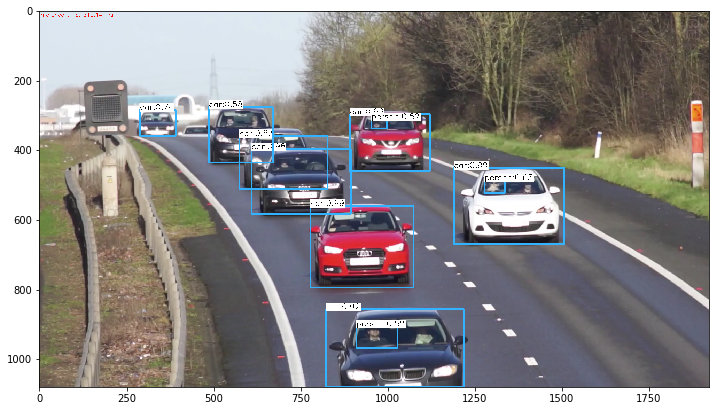

In [8]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.figure(figsize = (12, 12))
plt.imshow(img)
cv.imwrite("out.jpg", img) 

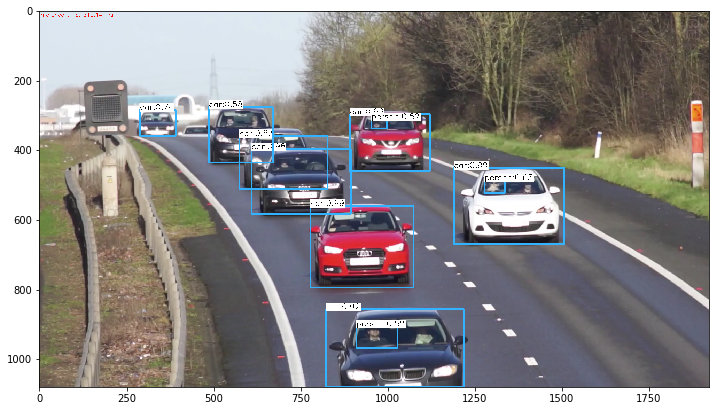

In [9]:
cv.imwrite("car.jpg", frame) 
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.figure(figsize = (12, 12))
plt.imshow(img)

In [10]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold C값을 의미, 0.5보다 낮은 애들은 다 제거한다. 얘를 높이면, object검출력이 떨어진다.
#0.5를 보통으로 쓴다.
nmsThreshold = 0.4   #Non-maximum suppression threshold, 거리가 가까운 애들은 한 그룹으로 보겠다. 얼마나 거리가 떨어져 있느냐에 따라서
inpWidth = 416       #Width of network's input image, 인풋이미지의 폭, 이건 정해져있다.
inpHeight = 416      #Height of network's input image, 인풋이미지의 높이, 이건 정해져있다.

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
#yolo3를 위해서는 기본적으로 2개가 필요하다. congfiguration(Layer 층) 파일과, 학습시켜놓은 결과인 weights
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

#
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

#YOLO3가 인식할 수 있는 클래스 80개가 나온다.

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [11]:
#네트워크에 있는 모든 레이어의 이름을 불러오는 함수
#실제 254개지만, 우리는 보통 같은 숫자로 묶여있는것을 하나로 친다. 연결되지 않은 레이어를 출력레이어로 본다.
#'yolo_106'이 마지막이 아니다. 사실 2개가 더 있다.
#yolo3에서 output은 3개다
l = net.getLayerNames()
print(l)
print(len(l))

#연결되지 않은 레이어들도 보여준다.
#얘네가 출력 3개
print(net.getUnconnectedOutLayers())

#i의 의미, 200, 227, 254, 즉 i[0] == 200, i[1] == 227, i[2] == 254
#1을 뺀 이유는 index가 0부터 시작해서, 0번째가 아닌, 첫번째 부터 하기 위함임
#[layersNames[i[0]-1] for i in net.getUnconnectedOutLayers()]

#yolo 계층 3개 출력
print(l[199])
print(l[226])
print(l[253])

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [12]:
#원하는 부분만 표시하기

# Get the names of the output layers
#여기를 이해하는게 중요하다.
#전체 레이어들의 이름을 가지고 와서, yolo layer들만 리턴하는 함수
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]



# Draw the predicted bounding box
# 찾은 다음에 박스 그리는 기능
#(0~79R까지의 값, 사람일 확률, 박스 위치 4개)
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label) #classid에 해당하는 이름을 가져온다. 아이디를 이름으로 바꾸어주는것

    #Display the label at the top of the bounding box
    #박스위에다가 클래스명 표시를 위해 박스 위치 계산
    
    #폰트의 크기, 베이스 라인 영어는 g,p,q,y같은게 baseline밑에 있다.
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    #x값은 그대로, y값만 조금 뺀다. baseline 때문이다.
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    #cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs): #이미지 영상의 높이와 폭을 가져온다.
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    
    #루프를 2번 돈다.
    #5번째부터 마지막까지가 확률값, 즉 0 많은 부분
    #대상자만 선별
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                if top > 800 and width > 300:
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    print(len(boxes))
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    print(indices)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [13]:
cap = cv.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))
y_82 = net.forward("yolo_82")
#13*13크기 yolo층 3개
print(y_82.shape)

detection = y_82[0][0:5]
print()

(507, 85)



2
[[0]]


True

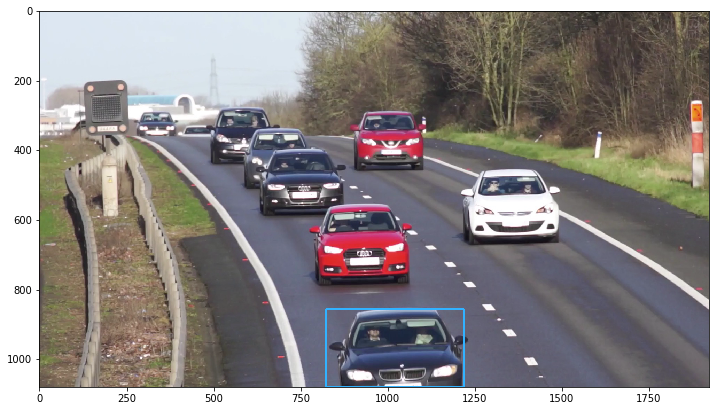

In [14]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
#label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
#cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.figure(figsize = (12, 12))
plt.imshow(img)
cv.imwrite("out.jpg", img) 

In [15]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    
    print(len(boxes))
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)    
    print(indices)    
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [16]:
cap = cv.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

#outs = net.forward(getOutputsNames(net))
y_82 = net.forward("yolo_82")
print(y_82.shape)

(507, 85)


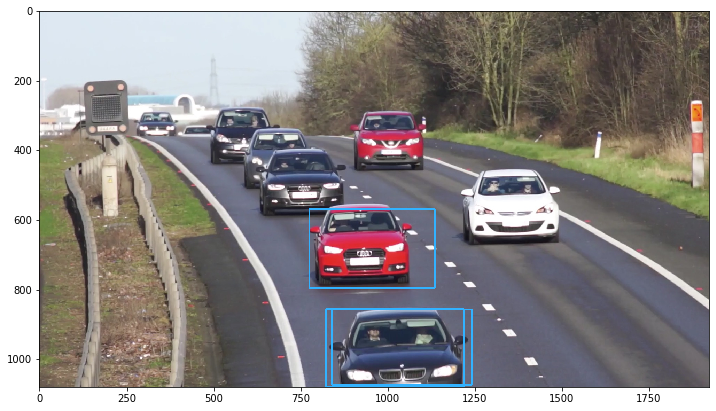

In [17]:
#총 507개 박스가 있을 것이다.
#13*13*3

#원하는 yolo layer 적용 82, 94, 106만 가능하다.
#셀수는 2배씩 증가
yolo = net.forward("yolo_82")

frame = cv.imread("cars.jpg")
frameHeight = frame.shape[0]
frameWidth = frame.shape[1]
    
for i in range(len(yolo))     :   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    
    if confidence > 0.01:
        #센터 좌표가 상대적으로 주어지기 때문에, 영상 크기만큼 곱해준다.
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        #왼쪽과 윗부분 좌표 구하기
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)        
        cv.rectangle(frame, (left, top), (left+width, top+height), (255, 178, 50), 3)
plt.figure(figsize = (12, 12))
imshow("", frame)

In [18]:
cells = []
print(len(yolo))
for i in range(len(yolo))     :   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    cells.append(classId)


507


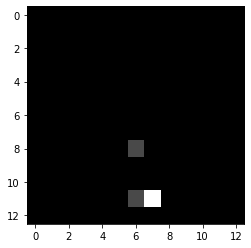

In [19]:
cells = np.array(cells)
cells = cells.reshape(13,13,3)
img = cells[:,:,0]*30
imshow("", img)

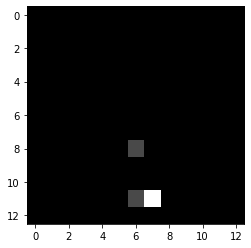

In [20]:
import math
np.random.randint(5, size = (80, 34))
cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3))

cells = cells.reshape(s, s, 3)
img = cells[:,:,0]*70
imshow("", img)

In [21]:
#강사님 답
cells = []
for i in range(len(yolo)):
    detection = yolo[i]
    scores = detection[5:]
    classId = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        cells.append(classId+1)
    else:
        cells.append(0)
cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3))
cells = cells.reshape(s, s, 3)

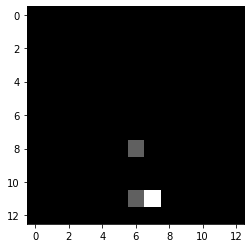

In [22]:
img = cells[:, :, 0]*30
imshow("", img)

In [23]:
#예측해야하는것은 boundary box다 class가 아니다.
#셀마다 대응

In [24]:
import cv2 as cv2
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
print(fourcc)
out = cv2.VideoWriter("output.avi", fourcc, 10, (513,400))
for i in range(60) :
    img1 = cv2.imread('book1.jpg')
    out.write(img1)    
out.release()

1482049860


In [25]:
img1.shape

(513, 400, 3)

In [27]:
import time
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter("vtest_out.avi", fourcc, 20.0, (576, 768))

cap = cv2.VideoCapture('vtest.avi')

for i in range(50) :
    ret, frame = cap.read()         
    blob = cv2.dnn.blobFromImage(frame, 1/255,
            (inpWidth, inpHeight), [0,0,0], True, crop=False)    
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net))    
    postprocess(frame, outs)
    video.write(frame) 
    cv2.waitKey(20)
    #time.sleep(0.05)
video.release()

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
cap = cv2.VideoCapture('vtest.avi')
ret, frame = cap.read()      
frame.shape

In [ ]:
frame.shape